# 1. Back testing of 2022 STI data with classification model and LSTM model

## 1.1 Load libraries

In [27]:
# Importing libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go
import plotly.offline as offline
import xgboost as xgb

## 1.2 Load previously learnt models from classification and LSTM

In [28]:
# Load previously learnt models
LSTM_univariate = load_model('LSTM_univariate.h5')
LSTM_multivariate = load_model('LSTM_multivariate.h5')

# Only work with these indicators: 'ema_period_5_diff', 'stochastic_period_5', 'force_index_5', 'macd_diff', 'stochastic_period_10'
# clf_stack = pickle.load(open("classification_stacked_model","rb"))
clf_xgb = xgb.XGBClassifier()
clf_xgb.load_model("clf_xgb.json")


## 1.3 Extract data from 2021 onwards and add necessary technical indicators

In [29]:
# Data from 2021 onwards to be use for back testing
# Loading STI's history into a dataframe
sti= yf.Ticker("^sti")
sti_df = sti.history(period='max')
sti_df.drop(["Dividends","Stock Splits"], axis=1, inplace=True)
back_testing_df = sti_df[sti_df.index.year>=2021]

In [30]:
def ema(file_name, period, price, smoothing = 2, column_name="ema_period"):
    
    """
    Calculation of EMA is as follows:

    EMA = (price * (smoothing / (1 + duration)) + previous_ema * (1 - (smoothing / (1 + duration)))

    """
    previous_ema = file_name.loc[:period, price].mean() #Getting average to be use as first ema
    
    ema_list = [previous_ema] # Storing first ema as a list and to store other ema values

    for i in range(period-1):
        #Insert 0 into elements before first EMA as first number period of values will not have ema values
        ema_list.insert(0, 0)
    
    # Calculating EMA for the rest
    for row_num in range(period, len(file_name[price])):
        current_price = file_name.loc[row_num, price]
        ema_temp = current_price * (smoothing / (1 + period)) + previous_ema * (1 - (smoothing / (1 + period)))
        previous_ema = ema_temp
        ema_list.append(ema_temp) # Appending of ema into list

    # Adding new column and add ema to it    
    file_name[f"{column_name}_{period}"] = ema_list

def macd(file_name):
    """
    Calculation for MACD as follows:
    MACD = ema_period_12 - ema_period_26
    Signal = ema_period_9 of MACD
    MACD_histogram = MACD - Signal

    Make sure dataframe has column "ema_period_26" and "ema_period_12"
    """

    file_name["macd"] = file_name["ema_period_12"] - file_name["ema_period_26"]
    ema(file_name, period=9, price="macd", column_name="signal_of_macd")
    file_name["macd_histogram"] = file_name["macd"] - file_name["signal_of_macd_9"]


def stochastic(file_name, period = 14, price = "Close"):
    """
    Calculation for stochastic is ((Closing_price - period_low) / (period_high - period_low)) * 100
    Period is define by user, default setting is 14
    Additional 2 columns will be created to show the high and low of the defined period
    """
    file_name[f"high_period_{period}"] = file_name[price].rolling(period).max()
    file_name[f"low_period_{period}"] = file_name[price].rolling(period).min()

    file_name[f"stochastic_period_{period}"] = ((file_name[price] - file_name[f"low_period_{period}"]) / (file_name[f"high_period_{period}"] - file_name[f"low_period_{period}"])) * 100

def force_index(file_name, period = 1, price = "Close"):
    """
    Default price use is "Close"
    Force Index(1) = {Close (current period)  -  Close (prior period)} x Volume
    Force Index(13) = 13-period EMA of Force Index(1)
    Change from yesterday close and today close will be calculate into a new column "close_diff"
    """
    file_name["close_diff"] = file_name[price].diff()
    file_name[f"force_index_period_{period}"] = file_name["close_diff"] * file_name["Volume"]


In [31]:
# Calculating ema
sti_df.reset_index(inplace=True) # Reset index for easier ema calculation
ema(sti_df,5,"Close")

# Calculating stochastic 
for i in [5, 10]:
    stochastic(sti_df, period = i)

# Adding force index period 1 feature into data
force_index(sti_df) # Default for force index, period 1 has to be calculated first before calculating other periods

# Calcuation of force index for period 5 by using ema on force index period 1
ema(sti_df,5,"force_index_period_1",column_name="force_index")

# Calculating ema for 12 and 26 periods to calculate macd
ema(sti_df,12,"Close")
ema(sti_df,26,"Close")
macd(sti_df)

In [32]:
# Change in force index period 5
sti_df["force_index_5_diff"] = sti_df["force_index_5"].diff()

# Calculating change of ema period 5
sti_df["ema_period_5_diff"] = sti_df["ema_period_5"].diff()

# Calculate the change from previous to current macd
sti_df["macd_diff"] = sti_df["macd"].diff()

# Classification based on change in ema period of 5 days, 1 for positive change and 0 for negative change
sti_df.loc[sti_df['ema_period_5_diff'] > 0, ['Next_day_movement']] = 1
sti_df.loc[sti_df['ema_period_5_diff'] <= 0, ['Next_day_movement']] = 0

# Shifting the current day movement to previous day to put it as label
sti_df['Next_day_movement'] = sti_df['Next_day_movement'].shift(-1)

# Removing first 25 data as ema calculation could not be done
sti_df = sti_df.iloc[25:]

# Remove data that has no volume/ no trades for classification model and reset index
sti_df.dropna(axis=0)# Dropna is to remove current day record which have no next day movement
sti_clf_df = sti_df[sti_df["Volume"] > 0] # Data to be use for classification model

# Set date to be index
sti_df.index = sti_df["Date"]
sti_clf_df.index = sti_clf_df["Date"]

# 1.4 Backtest of data
Data from 2022 onwards have not been seen by any of the model yet<br>
Classification model and LSTM model will be combined to give a final prediction<br>
Backtest will be done on 2022 date with the following strategy and assumption<br>
-If currently no position in market, will take up the first prediction direction(long/short)<br>
-If currently position is in market, will check next prediction whether is it the same as currently position(buy prediction with current long position)<br>
-If next prediction is not in favour of current position(sell prediction with current long position), will exit current position and take up the prediction direction(sell current long position and sell again to take up a short position)<br>
-Assuming buy and sell price is exactly at closing price of the prediction appear

## 1.4.1 Peparing of the data by separating into before and after 2022 data and scaling

In [33]:
# Serparating data into before and after 2022
sti_clf_df_before_2022 = sti_clf_df.loc[sti_clf_df.index.year < 2022]
sti_clf_df_2022 = sti_clf_df.loc[sti_clf_df.index.year == 2022]
sti_df_before_2022 = sti_df.loc[sti_df.index.year < 2022]
sti_df_2022 = sti_df.loc[sti_df.index.year == 2022]

# Slice data before 2022 into X for fitting into scaling for classification
clf_X_before_2022 = sti_clf_df_before_2022[['ema_period_5_diff', 'stochastic_period_5', 'force_index_5', 'macd_diff', 'stochastic_period_10']]

# Separating 2022 data into x and y for classification
clf_X_2022 = sti_clf_df_2022[['ema_period_5_diff', 'stochastic_period_5', 'force_index_5', 'macd_diff', 'stochastic_period_10']]
clf_y_2022 = sti_clf_df_2022["Next_day_movement"]

# Extract Closing price as array for date before and after 2022 for univariate LSTM
univariate_lstm_before_2022 = sti_df_before_2022[["Close"]].values # Array need to be in 2D
univariate_lstm_2022 = sti_df_2022[["Close"]].values

# Extract Closing price as array for date before and after 2022 for multivariate LSTM
multivariate_lstm_before_2022 = sti_df_before_2022[["ema_period_5_diff", "stochastic_period_5", "macd_diff", "stochastic_period_10", "Close"]].values
multivariate_lstm_2022 = sti_df_2022[["ema_period_5_diff", "stochastic_period_5", "macd_diff", "stochastic_period_10", "Close"]].values

In [34]:
# Perform scaling to trasform data between zero and one
mmc_clf = MinMaxScaler()
mmc_lstm = MinMaxScaler()
mmc_lstm_multi = MinMaxScaler()

# Fitting data before 2022 and then transform 2022 classification data into scaled data
mmc_clf.fit(clf_X_before_2022)
testing_set_scaled = mmc_clf.transform(clf_X_2022)

# Fitting closing price before 2022 and then transform 2022 classification closing price into scaled data
univariate_lstm_before_2022_scaled = mmc_lstm.fit_transform(univariate_lstm_before_2022)
univariate_lstm_2022_scaled = mmc_lstm.transform(univariate_lstm_2022)

# Fitting closing price before 2022 and then transform 2022 classification closing price into scaled data
multivariate_lstm_before_2022_scaled = mmc_lstm_multi.fit_transform(multivariate_lstm_before_2022)
multivariate_lstm_2022_scaled = mmc_lstm_multi.transform(multivariate_lstm_2022)

In [35]:
# Restructure input to have a certain a amount of steps to one output for univariate
X_lstm = []

# Combine last 50 training data from before 2022 with 2022 data
closing_price_2022_scaled = np.vstack((univariate_lstm_before_2022_scaled[-50:], univariate_lstm_2022_scaled))

# 50 price/steps for one input
for i in range(50, len(closing_price_2022_scaled)):
    X_lstm.append(closing_price_2022_scaled[i-50:i, 0])

X_lstm = np.array(X_lstm)

In [36]:
# Restructure input to have a certain a amount of steps to one output for multivariate
X_lstm_multivariate = []

# Combine last 50 training data before 2022 with 2022 data
multi_closing_price_2022_scaled = np.vstack((multivariate_lstm_before_2022_scaled[-50:], multivariate_lstm_2022_scaled))

# 50 price/steps for one input
for i in range(50, len(multi_closing_price_2022_scaled)):
    X_lstm_multivariate.append(multi_closing_price_2022_scaled[i-50:i,:])

X_lstm_multivariate = np.array(X_lstm_multivariate)

## 1.4.2 Predicting 2022 movement or prices with classification and lstm models

In [37]:
# Predict classification label with the validation data
clf_predict = clf_xgb.predict(testing_set_scaled)

In [38]:
# Predict next day closing price with LSTM model
# Finding the predictions and inverse transform for plotting
prediction = LSTM_univariate.predict(X_lstm)
prediction_inverse = mmc_lstm.inverse_transform(prediction)

8/8 [==============================] - 3s 14ms/step


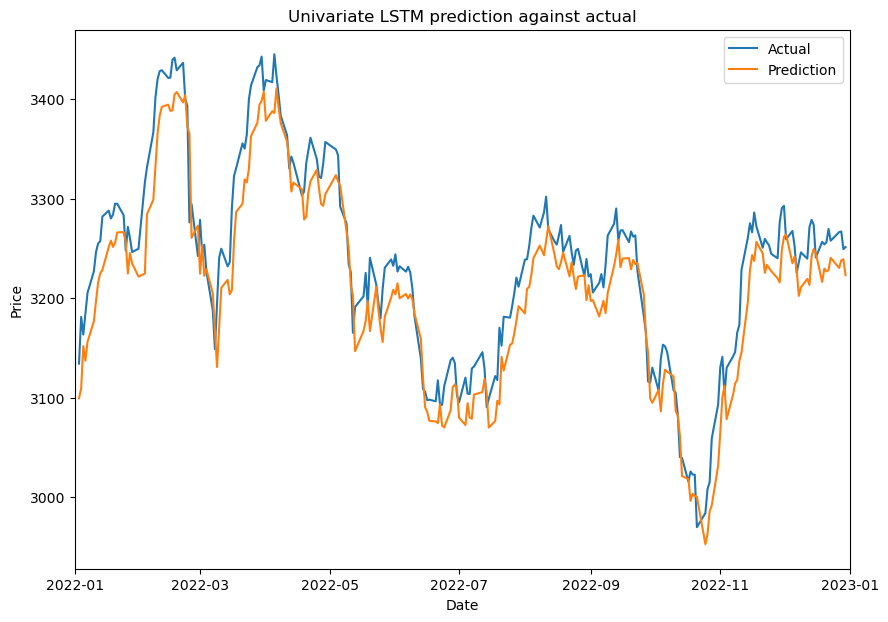

In [39]:
# Combine actual and prediction as dataframe for plotting
actual_predict_df = sti_df[sti_df.index.year == 2022][["Close"]]
actual_predict_df["prediction"] = prediction_inverse

# Plotting prediction with actual values
plt.figure(figsize = (10,7))
plt.plot(actual_predict_df, label=["Actual","Prediction"])
plt.xlim(pd.to_datetime(2022, format="%Y"),pd.to_datetime(2023, format="%Y") )
plt.title("Univariate LSTM prediction against actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

## 1.4.3 Predicting 2022 movement by using multivariate lstm model

In [40]:
# Predict next day closing price with LSTM model
# Finding the predictions and inverse transform for plotting
multi_lstm_prediction = LSTM_multivariate.predict(X_lstm_multivariate)
multi_lstm_prediction = np.concatenate((multi_closing_price_2022_scaled[50:,0:4], multi_lstm_prediction), axis=1)
multi_lstm_prediction_inverse = mmc_lstm_multi.inverse_transform(multi_lstm_prediction)

8/8 [==============================] - 1s 14ms/step


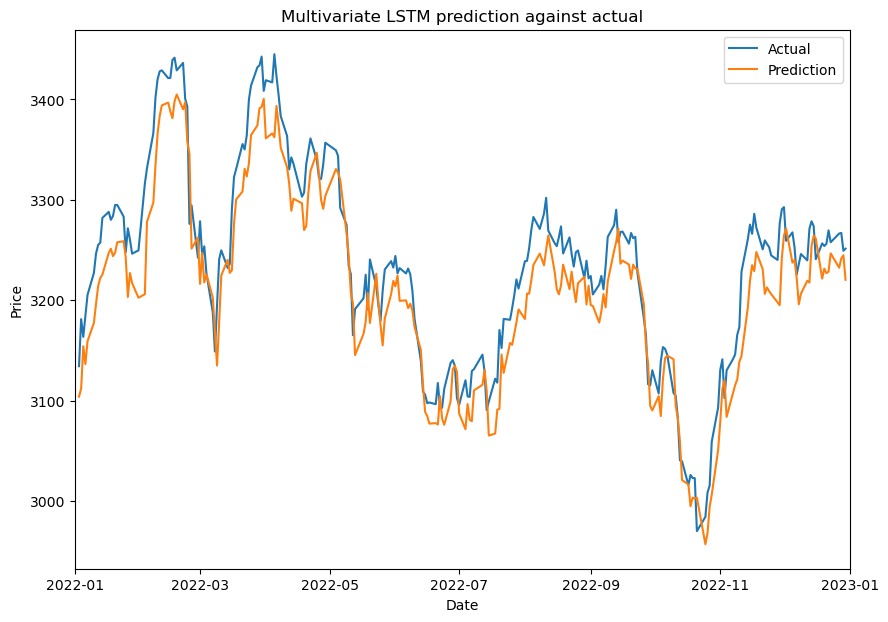

In [41]:
# Combine actual and prediction as dataframe for plotting
actual_predict_df = sti_df[sti_df.index.year == 2022][["Close"]]
actual_predict_df["prediction"] = multi_lstm_prediction_inverse[:,-1]

# Plotting prediction with actual values
plt.figure(figsize = (10,7))
plt.plot(actual_predict_df, label=["Actual","Prediction"])
plt.xlim(pd.to_datetime(2022, format="%Y"),pd.to_datetime(2023, format="%Y"))
plt.title("Multivariate LSTM prediction against actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# 2. Trading simulation with 2022 data

## 2.1 Combining all models predictions with actual labels and closing prices

In [42]:
# Slice closing price and next day movement for back test
back_test_df = sti_df[sti_df.index.year == 2022][["Close","Next_day_movement","Date"]]
back_test_df.index = back_test_df["Date"]
back_test_df.drop("Date", axis=1, inplace=True)

In [43]:
# Insert predictions into dataframe
back_test_df["clf_prediction"] = clf_predict
back_test_df["lstm_univariate_prediction"] = prediction_inverse
back_test_df["lstm_multivariate_prediction"]= multi_lstm_prediction_inverse[:,-1]

# Convert multivariate LSTM prediction into 1 or 0
back_test_df["lstm_multivariate_prediction"] = back_test_df["lstm_multivariate_prediction"].diff() # Calculate from yesterday prediction
back_test_df["lstm_multivariate_prediction"].shift(-1)
back_test_df.loc[back_test_df["lstm_multivariate_prediction"] < 0, ["lstm_multivariate_prediction"]] = 0
back_test_df.loc[back_test_df["lstm_multivariate_prediction"] > 0, ["lstm_multivariate_prediction"]] = 1

# Convert LSTM prediction into into 1 or 0
back_test_df["lstm_univariate_prediction"] = back_test_df["lstm_univariate_prediction"].diff() # Calculate from yesterday prediction
back_test_df["lstm_univariate_prediction"].shift(-1)
back_test_df.loc[back_test_df["lstm_univariate_prediction"] < 0, ["lstm_univariate_prediction"]] = 0
back_test_df.loc[back_test_df["lstm_univariate_prediction"] > 0, ["lstm_univariate_prediction"]] = 1

# Drop na
back_test_df.dropna(inplace = True)

In [61]:
# Combining different models predictions
back_test_df.loc[(back_test_df["lstm_univariate_prediction"] == back_test_df["lstm_multivariate_prediction"]) & (back_test_df["lstm_univariate_prediction"] == 1), ["combine_lstm_prediction"]] = 1
back_test_df.loc[(back_test_df["lstm_univariate_prediction"] == back_test_df["lstm_multivariate_prediction"]) & (back_test_df["lstm_univariate_prediction"] == 0), ["combine_lstm_prediction"]] = 0

back_test_df.loc[(back_test_df["lstm_univariate_prediction"] == back_test_df["clf_prediction"]) & (back_test_df["lstm_univariate_prediction"] == 1), ["univariate_clf_prediction"]] = 1
back_test_df.loc[(back_test_df["lstm_univariate_prediction"] == back_test_df["clf_prediction"]) & (back_test_df["lstm_univariate_prediction"] == 0), ["univariate_clf_prediction"]] = 0

back_test_df.loc[(back_test_df["lstm_multivariate_prediction"] == back_test_df["clf_prediction"]) & (back_test_df["lstm_multivariate_prediction"] == 1), ["multivariate_clf_prediction"]] = 1
back_test_df.loc[(back_test_df["lstm_multivariate_prediction"] == back_test_df["clf_prediction"]) & (back_test_df["lstm_multivariate_prediction"] == 0), ["multivariate_clf_prediction"]] = 0

back_test_df.loc[(back_test_df["lstm_multivariate_prediction"] == back_test_df["clf_prediction"]) & (back_test_df["clf_prediction"] == back_test_df["lstm_univariate_prediction"]) & (back_test_df["lstm_multivariate_prediction"] == 1), ["combine_prediction"]] = 1
back_test_df.loc[(back_test_df["lstm_multivariate_prediction"] == back_test_df["clf_prediction"]) & (back_test_df["clf_prediction"] == back_test_df["lstm_univariate_prediction"]) & (back_test_df["lstm_multivariate_prediction"] == 0), ["combine_prediction"]] = 0

# Change column names
back_test_df.columns = ["Close", "Next_day_movement", "Classification", "Univariate", "Multivariate", "Univariate + Multivariate", "Classification + Univariate", "Classification + Multivariate", "Combine"]

# Data with no predictions will be filled with no_predictions
back_test_df.fillna("no_prediction")

,Close,Next_day_movement,Classification,Univariate,Multivariate,Univariate + Multivariate,Classification + Univariate,Classification + Multivariate,Combine
Date,,,,,,,,,
2022-01-04,3181.129883,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0
2022-01-05,3163.439941,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0
2022-01-06,3184.300049,1.0,1,0.0,0.0,0.0,no_prediction,no_prediction,no_prediction
2022-01-07,3205.260010,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0
2022-01-10,3227.050049,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-12-23,3257.699951,1.0,0,1.0,1.0,1.0,no_prediction,no_prediction,no_prediction
2022-12-27,3266.379883,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-28,3266.969971,0.0,0,1.0,1.0,1.0,no_prediction,no_prediction,no_prediction


## 2.2 Plotting of confusion matrix of classification and LSTM models

Text(0.5, 1.0, 'Heatmap for lstm multivariate prediction')

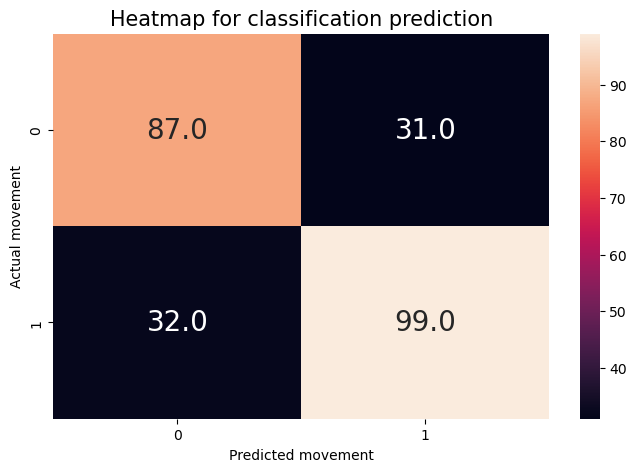

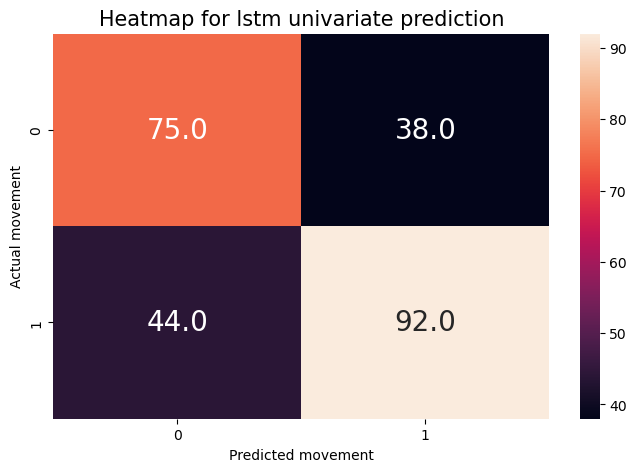

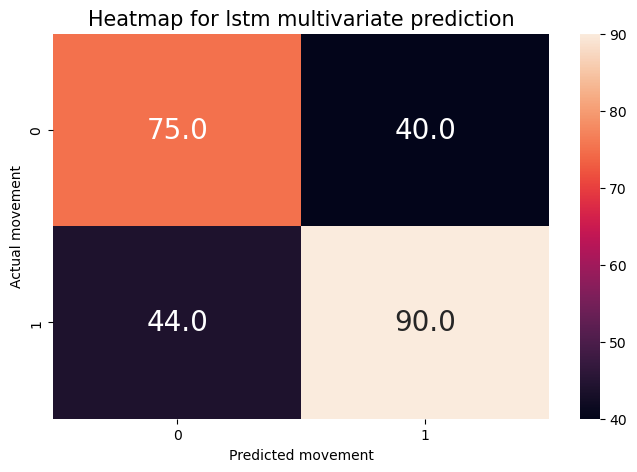

In [63]:

# Plotting confusion matrix heatmap for classification prediction
cm = confusion_matrix(back_test_df["Classification"], back_test_df["Next_day_movement"])
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f",  ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap for classification prediction", fontsize=15)

# Plotting confusion matrix heatmap for LSTM prediction
cm = confusion_matrix(back_test_df["Univariate"], back_test_df["Next_day_movement"])
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f",  ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap for lstm univariate prediction", fontsize=15)

cm = confusion_matrix(back_test_df["Multivariate"], back_test_df["Next_day_movement"])
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f",  ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap for lstm multivariate prediction", fontsize=15)


## 2.3 Trading simulation based on model predictions

In [64]:
def trading_simulation(df, predictions):
    """
    Predictions generated by models be use as trading simulation. Predictions for the period must be either 1 for predicting up 
    or 0 for predicting down or no_prediction for no prediction generated and no actions to be taken. This simulation will adopt
    a strategy of always having either a buy or a short position at one time in the market. When the trading simulation start, it 
    will use the first prediction of buy or sell to enter the market.

    If the next prediction is the same as current position, position is hold. If the next prediction is against current position, 
    current position is closed and new position to be taken with the next prediction.

    The simulation also assume all trading prices occurs at closing price where the prediction appear.

    Buy prices, buy dates, sell prices and sell dates are stored into different lists and return as two dataframes of short and long

    """
    # Simulate buy or sell scenario with prediction from model on 2022 data
    current_position = 0 # Start off with no position in market
    long_position_prices = [] # To store buy prices and exit prices
    short_position_prices = [] # To store sell prices and exit prices
    long_position_date = [] # To store buy and exit dates
    short_position_date =[] # To store buy and exit dates

    for prediction, price, date in zip(df[predictions], df["Close"], df.index):
        if current_position == 0 and prediction == 0: # No position with sell prediction
            current_position = -1
            short_position_prices.append(price)
            short_position_date.append(date)

        elif current_position == 0 and prediction == 1: # No position with buy prediction
            current_position = 1
            long_position_prices.append(price)
            long_position_date.append(date)

        elif current_position == 1 and prediction == 0: # Currently with long position with sell prediction
            current_position = -1
            long_position_prices.append(price) # Sell current long position
            long_position_prices.append(np.nan)
            long_position_date.append(date)
            long_position_date.append(np.nan)
            short_position_prices.append(price) # Enter new short position
            short_position_date.append(date)

        elif current_position == -1 and prediction == 1: # Currently with short position with buy prediction
            current_position = 1
            short_position_prices.append(price) # Buy back current short position
            short_position_prices.append(np.nan) 
            short_position_date.append(date)
            short_position_date.append(np.nan)
            long_position_prices.append(price) # Enter new long position
            long_position_date.append(date)
    short_position = pd.DataFrame(short_position_date,columns=["Date"])
    long_position = pd.DataFrame(long_position_date,columns=["Date"]) 
    short_position["Price"] = short_position_prices
    long_position["Price"] = long_position_prices
    return long_position, short_position

## 2.4 Plotting of trading simulation

In [65]:
def trading_simulation_plot(df, long_position_df, short_position_df, model):
    # Trace for short positions
    trace0 = go.Scatter(
        
        x = short_position_df["Date"],
        y = short_position_df["Price"],
        
        name = 'Short positions',
        
        line = dict(color = ('red'),
                    width = 2)
    )

    # Trace for long positions
    trace1 = go.Scatter(
        
        x = long_position_df["Date"],
        y = long_position_df["Price"],
        
        name = 'Long positions',
        
        line = dict(color = ('blue'),
                    width = 2)
    )

    # Trace for closing price
    trace2 = go.Scatter(
        
        x = df.index,
        y = df["Close"],
        
        name = 'Closing price',
        
        line = dict(color = ('green'),
                    width = 1),
    )

    # Plotting out entry and exits done
    data = [trace0, trace1, trace2]

    layout = dict(title = f"Trading simulation plot of {model} predictions",
                font=dict(size=18),
                xaxis = dict(title = 'Date'),
                yaxis = dict(title = 'Price'),
                )

    fig = dict(data=data, layout=layout)

    offline.iplot(fig)

In [66]:
# Plotting for each different predictions
for prediction in back_test_df.columns[2:]:
    long_position, short_position = trading_simulation(back_test_df, prediction)
    trading_simulation_plot(back_test_df, long_position, short_position, prediction)

In [67]:
# Compiling different trading simulations results
columns_for_results = ["Number of trades", "Number of buy trades", "Number of sell trades", "Long positions profit", "Short positions profit", "Total profit"]
trading_simulations_results = pd.DataFrame(index = columns_for_results)
for prediction in back_test_df.columns[2:]:
    long_position, short_position = trading_simulation(back_test_df, prediction)
    buy = long_position["Price"].diff().dropna()
    sell = short_position["Price"].diff().dropna()*-1 # Change profit to a positive number as it is shorting trades
    trading_simulations_results[prediction] = [(len(buy)+len(sell)) , len(buy), len(sell), round(buy.sum(),2), round(sell.sum(),2), round((buy.sum() + sell.sum()),2)]

trading_simulations_results

,Classification,Univariate,Multivariate,Univariate + Multivariate,Classification + Univariate,Classification + Multivariate,Combine
Number of trades,63.00,113.00,115.00,107.00,31.00,31.00,31.00
Number of buy trades,32.00,57.00,58.00,54.00,16.00,16.00,16.00
Number of sell trades,31.00,56.00,57.00,53.00,15.00,15.00,15.00
Long positions profit,327.40,383.89,354.46,360.63,451.69,431.27,451.69
Short positions profit,250.83,313.70,284.27,290.44,366.44,346.02,366.44
Total profit,578.23,697.59,638.73,651.07,818.13,777.29,818.13


In [68]:
trading_simulations_results.T[["Number of buy trades","Number of sell trades"]]

,Number of buy trades,Number of sell trades
Classification,32.0,31.0
Univariate,57.0,56.0
Multivariate,58.0,57.0
Univariate + Multivariate,54.0,53.0
Classification + Univariate,16.0,15.0
Classification + Multivariate,16.0,15.0
Combine,16.0,15.0


[Text(0, 0, '31'),
 Text(0, 0, '56'),
 Text(0, 0, '57'),
 Text(0, 0, '53'),
 Text(0, 0, '15'),
 Text(0, 0, '15'),
 Text(0, 0, '15')]

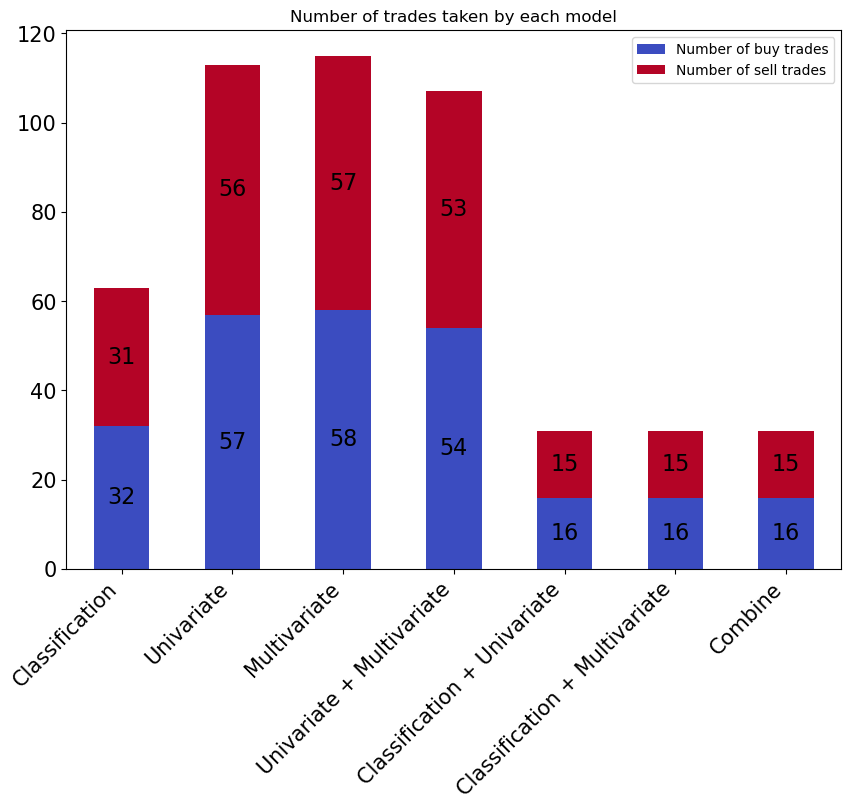

In [69]:
# Plotting of number of trades
xlabels=["Classification", "Univariate", "Multivariate", "Univariate + Multivariate", "Classification + Univariate", "Classification + Multivariate", "Combine"]
fig, ax = plt.subplots(figsize=(10,7))
bar_plot = trading_simulations_results.T[["Number of buy trades","Number of sell trades"]].plot(kind="bar", stacked=True, colormap="coolwarm", fontsize=15 ,ax=ax)
ax.set_xticklabels(xlabels, rotation=45, ha='right')
plt.title("Number of trades taken by each model")
plt.bar_label(bar_plot.containers[0], size=16, label_type="center")
plt.bar_label(bar_plot.containers[1], size=16, label_type="center")


[Text(0, 0, '250.83'),
 Text(0, 0, '313.7'),
 Text(0, 0, '284.27'),
 Text(0, 0, '290.44'),
 Text(0, 0, '366.44'),
 Text(0, 0, '346.02'),
 Text(0, 0, '366.44')]

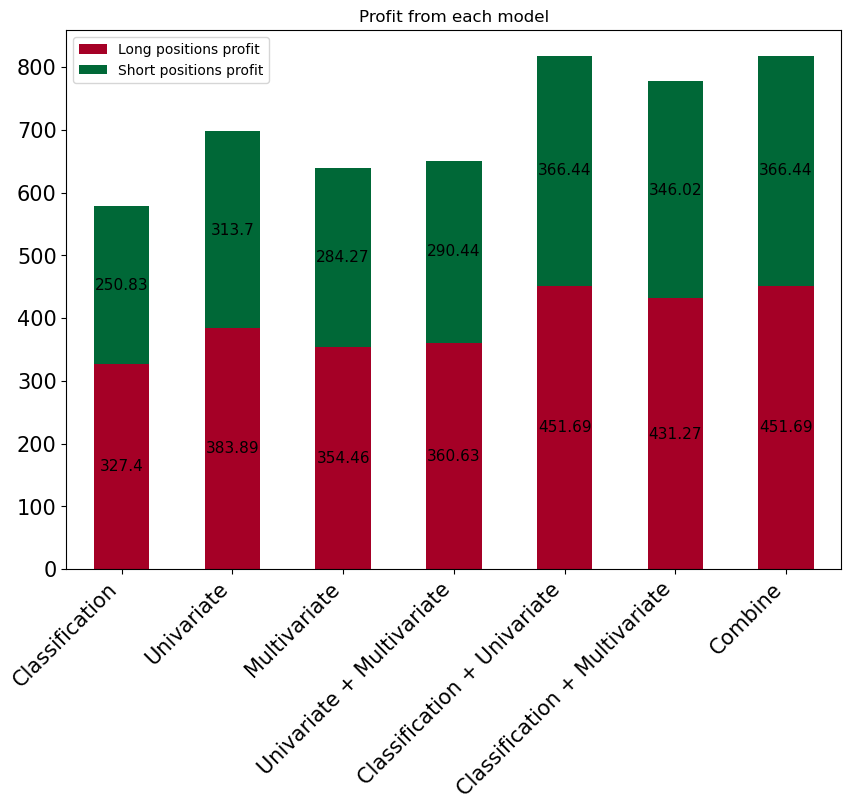

In [70]:
# Plotting of profit for each model
fig, ax = plt.subplots(figsize=(10,7))
bar_plot = trading_simulations_results.T[["Long positions profit","Short positions profit"]].plot(kind="bar", stacked=True, fontsize=15, colormap='RdYlGn',ax=ax)
ax.set_xticklabels(xlabels, rotation=45, ha='right')
plt.title("Profit from each model")
plt.bar_label(bar_plot.containers[0], size=11, label_type="center")
plt.bar_label(bar_plot.containers[1], size=11, label_type="center")